# The Facility Dispersion Problem

## p-dispersion

$$
\begin{align}
    \text{max} \quad & D \\
    \text{s.t} \quad & \sum_{i \in V} x_{i} = p & \forall \; i \in V \\
    & z_{i, j} \leq x_{i} & \forall \; i, j \in A \\
    & z_{i, j} \leq x_{j} & \forall \; i, j \in A \\
    & x_{i} + x_{j} - 1 \leq z_{i, j} & \forall \; i, j \in A \\
    & D \leq d_{i, j} + M (1 - z_{i, j}) & \forall \; i, j \in A \\
    & x_{i} \in \{0, 1\} & \forall \; i \in V \\
    & z_{i, j} \in \{0, 1\} & \forall \; i, j \in A \\
\end{align}
$$

## maxisum

$$
\begin{align}
    \text{max} \quad & \sum_{i \in V}\sum_{j \in V} d_{i, j} z_{i, j} \\
    \text{s.t} \quad & d_{opt} \leq D \\
\end{align}
$$

In [1]:
import json

import numpy as np
from scipy.spatial.distance import pdist, squareform
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Read input data

In [2]:
# Read file
with open("./data/data_25_5.json", mode="r") as file:
    data = json.load(file)

N = len(data["coordinates"])
coordinates = np.array(data["coordinates"])
weights = squareform(pdist(coordinates))

# Number of points to select
p = data["p"]

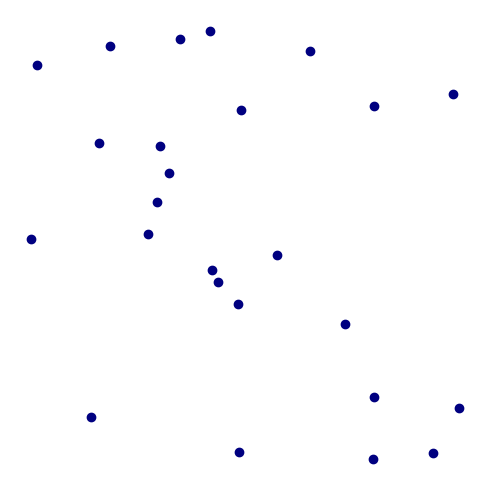

In [26]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)
ax.scatter(
    coordinates[:, 0],
    coordinates[:, 1],
    color="navy"
)

ax.axis('off')

fig.tight_layout()
plt.show()

## pyomo model

In [27]:
# Instantiate pyomo ConcreteModel
model = pyo.ConcreteModel()

In [28]:
# Sets of nodes and arcs
model.V = pyo.Set(initialize=range(weights.shape[0]))
model.A = pyo.Set(
    initialize=[(i,j) for i in range(weights.shape[0]) 
                for j in range(weights.shape[0]) 
                if i != j ]
)

In [29]:
# Parameters
model.d = pyo.Param(model.A, initialize={(i,j): weights[i, j] for (i,j) in model.A})
model.p = pyo.Param(initialize=p)

# Big M
model.M = pyo.Param(initialize = max(model.d[:,:]) - min(model.d[:,:]))

In [30]:
# Decision variables
model.x = pyo.Var(model.V, within=pyo.Binary)
model.z = pyo.Var(model.A, within=pyo.Binary)
model.D = pyo.Var(within=pyo.NonNegativeReals)

In [31]:
# Constraints
def p_selection(model):
    return sum(model.x[:]) == model.p


def dispersion_c1(model, i, j):
    return model.z[i,j] <= model.x[i]


def dispersion_c2(model, i, j):
    return model.z[i,j] <= model.x[j]


def dispersion_c3(model, i, j):
    return model.x[i] + model.x[j] - 1 <= model.z[i,j]


def maxmin_rule(model, i, j):
    return model.D <= model.d[i,j] + model.M*(1 - model.z[i,j])


#Set model attributes
model.p_selection = pyo.Constraint(rule=p_selection)
model.dispersion_c1 = pyo.Constraint(model.A, rule=dispersion_c1)
model.dispersion_c2 = pyo.Constraint(model.A, rule=dispersion_c2)
model.dispersion_c3 = pyo.Constraint(model.A, rule=dispersion_c3)
model.maxmin_rule = pyo.Constraint(model.A, rule=maxmin_rule)

In [32]:
#Objectives
model.obj_pdisp = pyo.Objective(expr=model.D, sense=pyo.maximize)


def obj_maxisum(model):
    return sum(model.d[i,j] * model.z[i,j] for (i,j) in model.A)


model.obj_maxisum = pyo.Objective(rule=obj_maxisum, sense=pyo.maximize)
model.obj_maxisum.deactivate()

## Solve

In [33]:
# Function to solve model
def solve_model(model, solver, **kwargs):

    # Solve p-dispersion problem
    solver.solve(model, **kwargs)

    # Include constraint that does not allow objective degradation
    d_opt = model.obj_pdisp()
    model.pdisp_degradation = pyo.Constraint(expr=d_opt <= model.D)

    # Change active objective
    model.obj_pdisp.deactivate()
    model.obj_maxisum.activate()

    # Solve maxisum model
    solver.solve(model, **kwargs)

In [34]:
solver = pyo.SolverFactory("appsi_highs")
solver.options["time_limit"] = 180
solve_model(model, solver, tee=True)

Presolving model
2401 rows, 626 cols, 5425 nonzeros
1200 rows, 326 cols, 2723 nonzeros
1200 rows, 326 cols, 2723 nonzeros

Solving MIP model with:
   1200 rows
   326 cols (325 binary, 0 integer, 0 implied int., 1 continuous)
   2723 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   1.25261538      -inf                 inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   1.25261538      0.1864407976     571.86%        0      0      0        27     0.0s
 C       0       0         0   0.00%   1.25261538      0.1900518979     559.09%       13      7      0        47     0.1s
 L       0       0         0   0.00%   1.149900063     0.1923910354     497.69%     3612     46     21       782     0.5s

4.0% inactive integer 

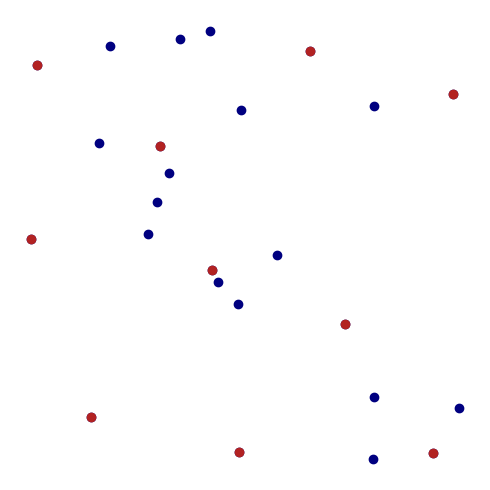

In [35]:
fig, ax = plt.subplots(figsize=[5, 5], dpi=100)
facilities = np.array([i for i in model.x if np.isclose(model.x[i].value, 1)])

ax.scatter(
    coordinates[:, 0],
    coordinates[:, 1],
    color="navy"
)

ax.scatter(
    coordinates[facilities, 0],
    coordinates[facilities, 1],
    color="firebrick",
    label="Facilities"
)

ax.axis('off')

fig.tight_layout()
plt.show()